# NIRSpec MSA shutter image

This notebook translates shutter (column, row) coordinates from the pipeline MSA metafile to the observed coordinate system as shown in APT.

The NIRSpec Micro-Shutter Assemly (MSA) coordinate system is shown on JDox:  
https://jwst-docs.stsci.edu/jwst-near-infrared-spectrograph/nirspec-instrumentation/nirspec-micro-shutter-assembly

The JWST pipeline generates an MSA metafile:  
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/msa_metadata.html  
that uses a different coordinate system:
* rows and columns are swapped
    * columns increment in the spatial direction
    * row numbers decrease in the dispersion direction
* numbers are continuous without gaps
    * the origin (0,0) is at top right
    * (730,342) is at bottom left
* quadrants are reordered as shown below:

NIRSpec MSA quadrants:  
Q3 Q1  
Q4 Q2  

MSA metafile coordinates:  
Q3 Q4  
Q2 Q1

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib as mpl
import copy

In [2]:
msa_metafile = 'jw02736007001_01_msa.fits'

In [3]:
msa_hdu_list = fits.open(msa_metafile)
msa_hdu_list.info()

Filename: jw02736007001_01_msa.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   ()      
  1  SHUTTER_IMAGE    1 ImageHDU         8   (342, 730)   int16   
  2  SHUTTER_INFO    1 BinTableHDU     33   1318R x 12C   [I, I, I, I, I, J, 1A, 6A, E, E, I, 1A]   
  3  SOURCE_INFO    1 BinTableHDU     25   119R x 8C   [J, J, 20A, 31A, D, D, 30A, D]   


In [4]:
shutter_image = msa_hdu_list['SHUTTER_IMAGE'].data[:].T

In [5]:
ny, nx = shutter_image.shape

Q4 = shutter_image[:ny//2, :nx//2]
Q3 = shutter_image[:ny//2, nx//2:]
Q1 = shutter_image[ny//2:, :nx//2]
Q2 = shutter_image[ny//2:, nx//2:]

msa_image = np.vstack((np.hstack((Q1, Q3)), np.hstack((Q2, Q4))))
msa_image.shape  # ny, nx

(342, 730)

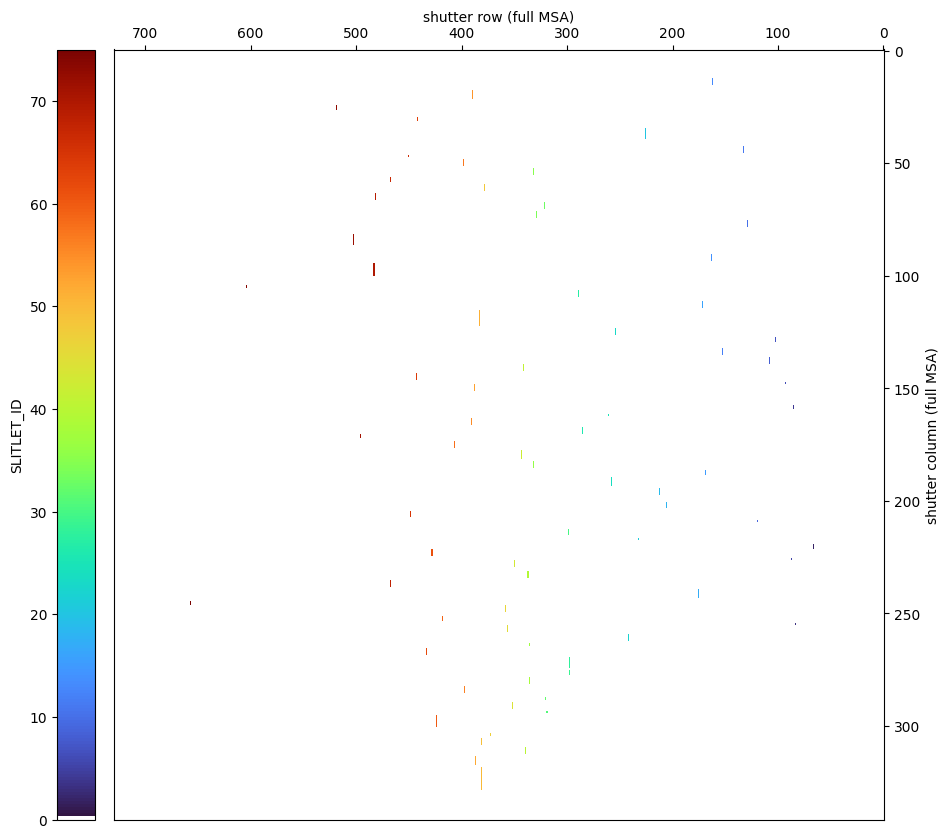

In [6]:
fig, ax = plt.subplots(figsize=(12,10))
cmap = copy.deepcopy(mpl.colormaps['turbo'])
cmap.colors[0] = 1, 1, 1
im = plt.imshow(msa_image, aspect=nx/ny, interpolation='nearest', origin='upper', cmap=cmap)
ax.invert_xaxis()
plt.xlabel('shutter row (full MSA)')
plt.ylabel('shutter column (full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')
cbar.set_label('SLITLET_ID')

# Pipeline MSA metafile shutter row, column

In [7]:
from astropy.table import Table, vstack, unique
shutter_table = Table(msa_hdu_list['SHUTTER_INFO'].data)
shutter_table1 = shutter_table[shutter_table['msa_metadata_id'] == 1]  # extract one of the MSA configurations
shutter_table_dither1 = shutter_table1[shutter_table1['dither_point_index'] == 1]  # first dither
shutter_table_dither1

slitlet_id,msa_metadata_id,shutter_quadrant,shutter_row,shutter_column,source_id,background,shutter_state,estimated_source_in_shutter_x,estimated_source_in_shutter_y,dither_point_index,primary_source
int16,int16,int16,int16,int16,int32,str1,str6,float32,float32,int16,str1
2,1,2,67,50,-1,Y,OPEN,nan,nan,1,N
2,1,2,67,51,-1,N,OPEN,0.5002731,0.49997795,1,Y
3,1,2,84,85,-2,N,OPEN,0.50021464,0.5000087,1,Y
4,1,1,86,159,-3,Y,OPEN,nan,nan,1,N
4,1,1,86,160,-3,N,OPEN,0.49981627,0.499644,1,Y
5,1,2,88,56,-4,N,OPEN,0.5003102,0.4999598,1,Y
6,1,1,94,149,-5,N,OPEN,0.49975815,0.49966425,1,Y
7,1,1,103,129,-6,Y,OPEN,nan,nan,1,N
7,1,1,103,130,-6,N,OPEN,0.4996756,0.49972537,1,Y


In [8]:
def even(x): # even vs. odd number
    return 1 - x % 2

quadrant = shutter_table_dither1['shutter_quadrant']
slitlet  = shutter_table_dither1['slitlet_id']

# row, column resets within each quadrant
row_in_quadrant    = shutter_table_dither1['shutter_row']
column_in_quadrant = shutter_table_dither1['shutter_column']

# row, column on full msa grid
row    = row_in_quadrant    + (quadrant > 2) * nx//2
column = column_in_quadrant + even(quadrant) * ny//2

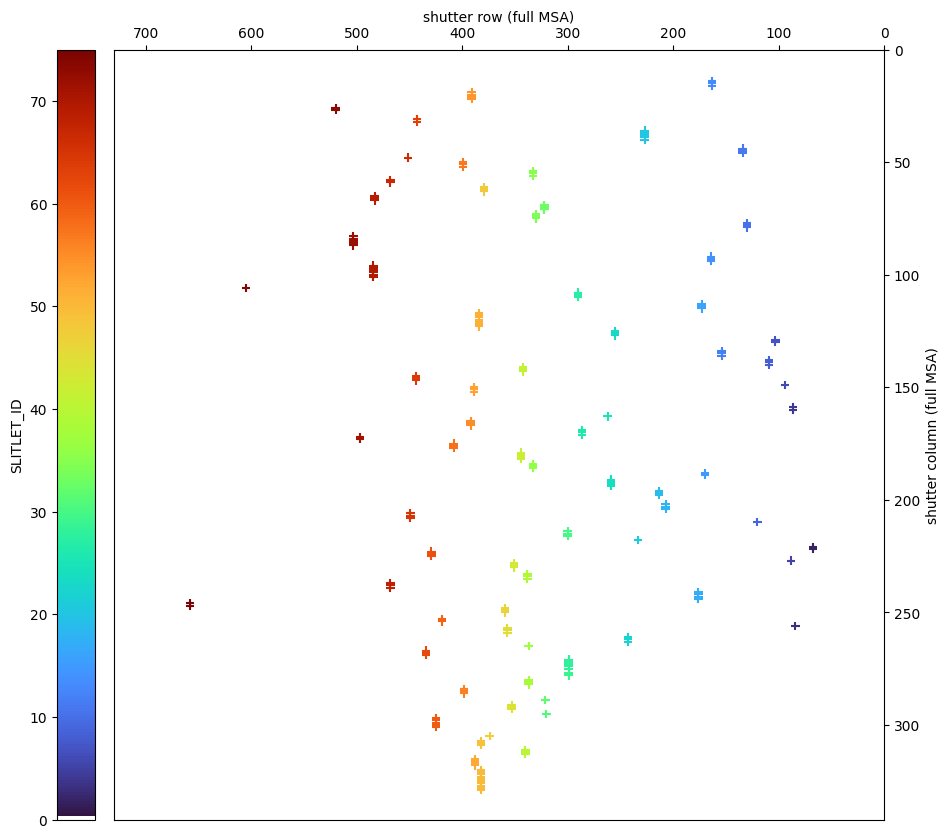

In [9]:
fig, ax = plt.subplots(figsize=(12,10))
plt.scatter(row, column, c=slitlet, marker='+', cmap=cmap, clim=(0,np.max(slitlet)))
plt.xlim(nx,0)
plt.ylim(ny,0)
plt.xlabel('shutter row (full MSA)')
plt.ylabel('shutter column (full MSA)')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.set_aspect(nx/ny)
cbar = fig.colorbar(im, ax=ax, shrink=1, aspect=20, pad=0.02, location='left')
cbar.set_label('SLITLET_ID')